In [1]:
import dynalearn
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import tensorflow.keras as keras
import tqdm
import os

In [2]:
def chain_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_node(i)
        g.add_edge(i - 1, i)
    g.name = 'chain_n{0}'.format(n)
    return g

def complete_graph(n):
    g = nx.complete_graph(n)
    g.name = 'complete_n{0}'.format(n)
    return g

def star_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_edge(0, i)
    g.name = 'star_n{0}'.format(n)
    return g

def regular_graph(n, d):
    g = nx.random_regular_graph(d, n)
    g.name = 'regular_n{0}_d{1}'.format(n, d)
    return g

def empty_graph(n):
    g = nx.empty_graph(n)
    g.name = 'empty_n{0}'.format(n)
    return g

def BA_tree_graph(n):
    g = nx.barabasi_albert_graph(n, 1)
    g.name = 'ba_tree_n{0}'.format(n)
    return g

def BA_graph(n, m):
    g = nx.barabasi_albert_graph(n, m)
    g.name = 'ba_n{0}_m{1}'.format(n, m)
    return g

def ER_graph(n, p):
    g = nx.gnp_random_graph(n, p)
    g.name = 'er_n{0}_p{1}'.format(n, p)
    return g

In [3]:
# Generating the network
n_nodes = 50
avgk = 10
inf_prob = 0.04
rec_prob = 0.08
T = 200
batch_size = None
gamma = 0.

train_sample = 10000

loss_value ={}
acc_value ={}

approach = "gatpred"
# graph = complete_graph(n_nodes)
# graph = chain_graph(n_nodes)
# graph = empty_graph(n_nodes)
# graph = star_graph(n_nodes)
# graph = BA_tree_graph(n_nodes)
graph = BA_graph(n_nodes, int(avgk / 2))
# graph = ER_graph(n_nodes, avgk)

f_prefix = 'data/' + approach + "_" + graph.name + "_SIS_inf{0}_rec{1}".format(inf_prob, rec_prob)
if not os.path.exists(f_prefix):
    os.mkdir(f_prefix)


valid_node_index = []
train_node_index = list(set(range(n_nodes)).difference(valid_node_index))
train_generator = dynalearn.datasets.SISGenerator(graph, inf_prob, rec_prob, batch_size,
                                                  init_param=0.05, shuffle=True,
                                                  with_structure=True, gamma=gamma,
                                                  prohibited_node_index=valid_node_index)
train_generator.generate(train_sample, T, tqdm.tqdm_notebook)


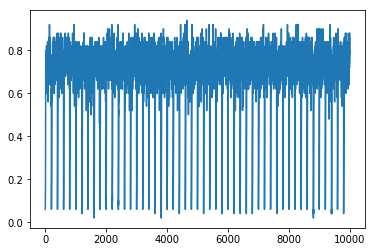

In [4]:
plt.plot(np.mean(train_generator.data_input, axis=1))
plt.show()

In [47]:
from dynalearn.models import GATBinaryMarkovPredictor

n_hidden = [32,32]
n_heads = 6
wd = 1e-4
dropout = 0.
gamma = 0.
epoch = 0

model = GATBinaryMarkovPredictor(graph, n_hidden, n_heads, weight_decay=wd, dropout=dropout)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
graph_attention_6 (GraphAttenti (None, 192)          768         input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
graph_attention_7 (GraphAttenti (None, 192)          37440       graph_attention_6[0][0]          
          

In [57]:
lr = 1e-5


optimizer = keras.optimizers.Adam(lr=lr)
loss = keras.losses.binary_crossentropy
schedule = lambda e: lr * (0.5)**(e//5)

callbacks = [keras.callbacks.LearningRateScheduler(schedule),
#              keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.2,
#                                                cooldown=5, patience=5,
#                                                verbose=1),
             keras.callbacks.ModelCheckpoint(os.path.join(f_prefix, 'model'),
                                             monitor='loss',
                                             save_best_only=True,
                                             verbose=0)
            ]
            
model._model.compile(optimizer, loss, metrics=['accuracy'])


In [58]:
history = model._model.fit_generator(train_generator,
                                     steps_per_epoch=10000,
                                     epochs=10,
                                     initial_epoch=0,
                                     verbose=1,
                                     callbacks=callbacks,
                                     shuffle=False)
epoch += 10

Epoch 1/10
10000/10000 [==============================] - 80s 8ms/step - loss: 0.3263 - acc: 0.8978

In [59]:
loss_value[gamma] = history.history['loss']
acc_value[gamma] = history.history['acc']

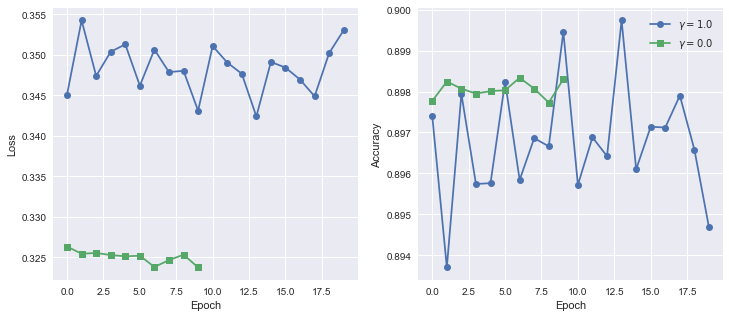

In [60]:
markers = ['o', 's', 'v', '*']

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, g in enumerate(loss_value.keys()):
    ax[0].plot(loss_value[g], linestyle='-', marker=markers[i%len(markers)])
    ax[1].plot(acc_value[g], linestyle='-', marker=markers[i%len(markers)], label=r'$\gamma={0}$'.format(g))

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()
    

In [61]:
def get_SIS_CLP(graph, infection_prob, recovery_prob, states, progress_bar=None):
    A = nx.to_numpy_array(graph)
    N = A.shape[0]
    
    prob = np.zeros([states.shape[0], N])

    inf_neighbors = np.matmul(A, states.T).T
    
    sus_to_sus_prob = {i: [] for i in range(N)}
    sus_to_inf_prob = {i: [] for i in range(N)}
    inf_to_sus_prob = {i: [] for i in range(N)}
    inf_to_inf_prob = {i: [] for i in range(N)}
    
    if progress_bar:
        bar = progress_bar(range(states.shape[0]), 'True')
    for i, s in enumerate(states):
        inf_neighbors = np.matmul(A, s)
        if progress_bar:
            bar.update()
        for j, inf in enumerate(inf_neighbors):
            if s[j] == 0:
                sus_to_sus_prob[int(inf)].append((1 - infection_prob)**inf)
                sus_to_inf_prob[int(inf)].append(1 - (1 - infection_prob)**inf)
            else:
                inf_to_sus_prob[int(inf)].append(recovery_prob)
                inf_to_inf_prob[int(inf)].append(1 - recovery_prob)

    if progress_bar:
        bar.close()
    
    return sus_to_sus_prob, sus_to_inf_prob, inf_to_sus_prob, inf_to_inf_prob


def get_learned_CLP(graph, model, states, progress_bar=None):
    N = graph.number_of_nodes()
    
    A = nx.to_numpy_array(graph) + np.eye(N)
    
#     prob = np.zeros([states.shape[0], N])
    sus_to_sus_prob = {i: [] for i in range(N)}
    sus_to_inf_prob = {i: [] for i in range(N)}
    inf_to_sus_prob = {i: [] for i in range(N)}
    inf_to_inf_prob = {i: [] for i in range(N)}

    if progress_bar:
        bar = progress_bar(range(states.shape[0]), 'Learned')
    for i, s in enumerate(states):
        p = np.squeeze(model.predict([s, A], steps=1)) + 1e-15
#         prob[i, :] = p[:,0]
        inf_neighbors = np.matmul(A, s)
        for j, inf in enumerate(inf_neighbors):
            if s[j] == 0:
                sus_to_sus_prob[int(inf)].append(1 - p[j])
                sus_to_inf_prob[int(inf)].append(p[j])
            else:
                inf_to_sus_prob[int(inf) - 1].append(1 - p[j])
                inf_to_inf_prob[int(inf) - 1].append(p[j])
        if progress_bar:
            bar.update()
        
    
    if progress_bar:
        bar.close()    
    
    return sus_to_sus_prob, sus_to_inf_prob, inf_to_sus_prob, inf_to_inf_prob


def get_transition_occurence(graph, in_states, out_states, progress_bar=None):
    N = graph.number_of_nodes()
    
    A = nx.to_numpy_array(graph) + np.eye(N)
    
    s_s_sparcity = [0 for i in range(N)]
    s_i_sparcity = [0 for i in range(N)]
    i_s_sparcity = [0 for i in range(N)]
    i_i_sparcity = [0 for i in range(N)]
    
    if progress_bar:
        bar = progress_bar(range(in_states.shape[0]), 'Ocurrence')
        
    for i in range(in_states.shape[0]):
        in_s = in_states[i, :]
        out_s = out_states[i, :]
        inf_neighbors = np.matmul(A, in_s)
        for j, inf in enumerate(inf_neighbors):
            if in_s[j] == 0 and out_s[j] == 0:
                s_s_sparcity[int(inf)] += 1
            elif in_s[j] == 0 and out_s[j] == 1:
                s_i_sparcity[int(inf)] += 1
            elif in_s[j] == 1 and out_s[j] == 0:
                i_s_sparcity[int(inf) - 1] += 1
            else:
                i_i_sparcity[int(inf) - 1] += 1
        if progress_bar:
            bar.update()
    
    if progress_bar:
        bar.close()

    s_s_sparcity = {i: s / np.sum(s_s_sparcity) for i, s in enumerate(s_s_sparcity)}
    s_i_sparcity = {i: s / np.sum(s_i_sparcity) for i, s in enumerate(s_i_sparcity)}
    i_s_sparcity = {i: s / np.sum(i_s_sparcity) for i, s in enumerate(i_s_sparcity)}
    i_i_sparcity = {i: s / np.sum(i_i_sparcity) for i, s in enumerate(i_i_sparcity)}
    
    return s_s_sparcity, s_i_sparcity, i_s_sparcity, i_i_sparcity


def get_estimate_from_data(graph, in_states, out_states, progress_bar=None):
    N = graph.number_of_nodes()
    
    A = nx.to_numpy_array(graph) + np.eye(N)
    
    s_s = {i:[] for i in range(N)}
    s_i = {i:[] for i in range(N)}
    i_s = {i:[] for i in range(N)}
    i_i = {i:[] for i in range(N)}
    
    if progress_bar:
        bar = progress_bar(range(in_states.shape[0]), 'Estimate')
        
    for i in range(in_states.shape[0]):
        in_s = in_states[i, :]
        out_s = out_states[i, :]
        inf_neighbors = np.matmul(A, in_s)
        for j, inf in enumerate(inf_neighbors):
            if in_s[j] == 0:
                s_s[int(inf)].append(1 - out_s[j])
                s_i[int(inf)].append(out_s[j])
            else:
                i_s[int(inf)].append(1 - out_s[j])
                i_i[int(inf)].append(out_s[j])
        if progress_bar:
            bar.update()
    
    if progress_bar:
        bar.close()

    return s_s, s_i, i_s, i_i

In [62]:
def plot_prob_vs_l(prob, ax, marker, linestyle, color, fill_color=None, label=None):
    if fill_color is None:
        fill_color = color
        
            
    keys = prob.keys()
    x = np.array([i for i in keys])
    y = np.array([np.mean(prob[i]) if len(prob)>0 else 0 for i in keys])
    
    err_y = np.array([np.std(prob[i]) / np.sqrt(len(prob)) if len(prob)>0 else 0  for i in keys])
    ax.fill_between(x, y - err_y, y + err_y, color=fill_color, alpha=0.3)
    ax.plot(x, y, marker=marker, ls=linestyle, c=color, label=label, lw=3,
            markeredgewidth=1, markeredgecolor='black')
    return x, y

/home/charles/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/charles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


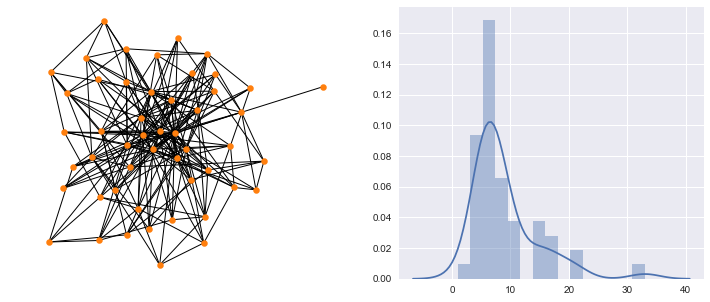

In [63]:
import seaborn

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

nx.draw(graph, node_size=20, node_color="#ff7f0e", linewidths=2, ax=ax[0])
degrees = list(dict(graph.degree()).values())
seaborn.distplot(degrees)

plt.show()


In [64]:
from random import sample

index = sample(range(train_sample), 1000)
index = list(range(train_sample))

in_states = train_generator.data_input[index]
out_states = train_generator.data_target[index]

s_s_real, s_i_real, i_s_real, i_i_real = get_SIS_CLP(graph, inf_prob, rec_prob, in_states,
                                                     tqdm.tqdm_notebook)
s_s_lear, s_i_lear, i_s_lear, i_i_lear = get_learned_CLP(graph, model._model, in_states,
                                                         tqdm.tqdm_notebook)
s_s_est, s_i_est, i_s_est, i_i_est = get_estimate_from_data(graph,
                                                            in_states,
                                                            out_states,
                                                            tqdm.tqdm_notebook)


/home/charles/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/charles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/charles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/charles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/charles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


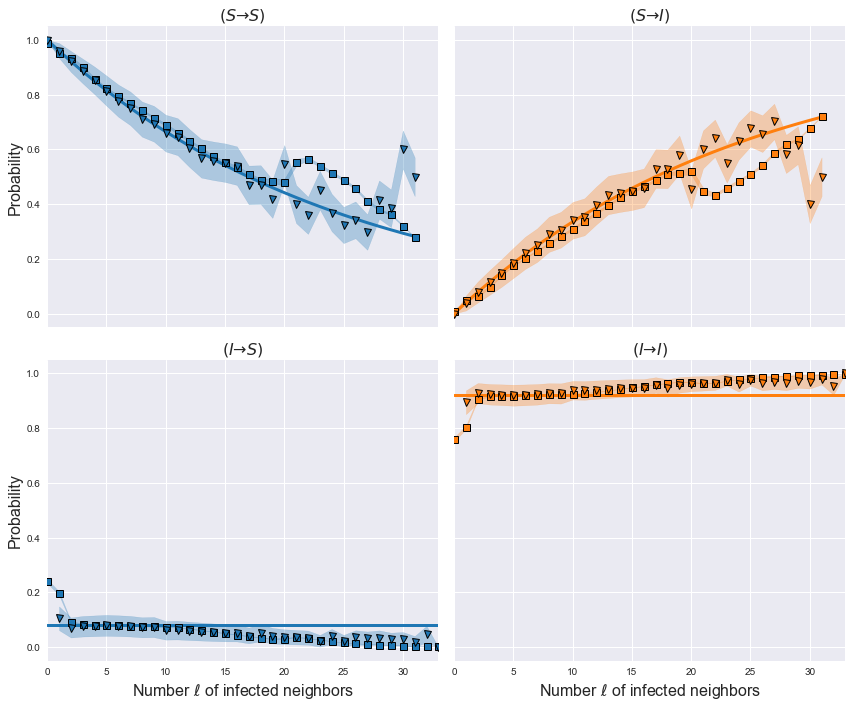

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axx = ax.copy()
plot_prob_vs_l(s_s_real, ax[0, 0], 'None', '-', '#1f77b4', 'grey')
plot_prob_vs_l(s_i_real, ax[0, 1], 'None', '-', '#ff7f0e', 'grey')
plot_prob_vs_l(i_s_real, ax[1, 0], 'None', '-', '#1f77b4', 'grey')
plot_prob_vs_l(i_i_real, ax[1, 1], 'None', '-', '#ff7f0e', 'grey')

plot_prob_vs_l(s_s_lear, ax[0, 0], 's', 'None', '#1f77b4')
plot_prob_vs_l(s_i_lear, ax[0, 1], 's', 'None', '#ff7f0e')
plot_prob_vs_l(i_s_lear, ax[1, 0], 's', 'None', '#1f77b4')
plot_prob_vs_l(i_i_lear, ax[1, 1], 's', 'None', '#ff7f0e')

plot_prob_vs_l(s_s_est, ax[0, 0], 'v', 'None', '#1f77b4')
plot_prob_vs_l(s_i_est, ax[0, 1], 'v', 'None', '#ff7f0e')
plot_prob_vs_l(i_s_est, ax[1, 0], 'v', 'None', '#1f77b4')
plot_prob_vs_l(i_i_est, ax[1, 1], 'v', 'None', '#ff7f0e')

ax[0, 0].set_title(r'$(S \to S)$', fontsize=16)
ax[0, 1].set_title(r'$(S \to I)$', fontsize=16)
ax[1, 0].set_title(r'$(I \to S)$', fontsize=16)
ax[1, 1].set_title(r'$(I \to I)$', fontsize=16)
ax[1, 0].set_xlabel(r'Number $\ell$ of infected neighbors', fontsize=16)
ax[1, 1].set_xlabel(r'Number $\ell$ of infected neighbors', fontsize=16)
ax[0, 0].set_ylabel(r'Probability', fontsize=16)
# ax[0, 1].set_ylabel(r'Probability', fontsize=16)
ax[1, 0].set_ylabel(r'Probability', fontsize=16)
# ax[1, 1].set_ylabel(r'Probability', fontsize=16)

# ax[0, 0].set_xlim([min(dict(graph.degree).values()), max(dict(graph.degree).values())])
ax[0, 0].set_xlim([0, max(dict(graph.degree).values())])
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[1,0].grid(True)
ax[1,1].grid(True)

# axx[0, 0] = ax[0, 0].twinx()
# axx[0, 1] = ax[0, 1].twinx()
# axx[1, 0] = ax[1, 0].twinx()
# axx[1, 1] = ax[1, 1].twinx()

# plot_prob_vs_l(s_s_trans, axx[0, 0], '*', 'None', 'grey')
# plot_prob_vs_l(s_i_trans, axx[0, 1], '*', 'None', 'grey')
# plot_prob_vs_l(i_s_trans, axx[1, 0], '*', 'None', 'grey')
# plot_prob_vs_l(i_i_trans, axx[1, 1], '*', 'None', 'grey')

# axx[0, 0].set_ylabel(r'Dataset occurence', fontsize=16)
# axx[0, 1].set_ylabel(r'Dataset occurence', fontsize=16)
# axx[1, 0].set_ylabel(r'Dataset occurence', fontsize=16)
# axx[1, 1].set_ylabel(r'Dataset occurence', fontsize=16)
# axx[0, 0].set_xlim([min(dict(graph.degree).values()), max(dict(graph.degree).values())])

plt.savefig(os.path.join(f_prefix, 'gamma{0}_epoch_{1}.png'.format(float(gamma), epoch)))
plt.tight_layout()
plt.show()

In [111]:

for layer in model._model.layers:
    for w in layer.weights:
        print(w.value)

<bound method ResourceVariable.value of <tf.Variable 'graph_attention_6/kernel_0:0' shape=(1, 32) dtype=float32>>
<bound method ResourceVariable.value of <tf.Variable 'graph_attention_6/bias_0:0' shape=(32,) dtype=float32>>
<bound method ResourceVariable.value of <tf.Variable 'graph_attention_6/attn_kernel_self_0:0' shape=(32, 1) dtype=float32>>
<bound method ResourceVariable.value of <tf.Variable 'graph_attention_6/attn_kernel_neigh_0:0' shape=(32, 1) dtype=float32>>
<bound method ResourceVariable.value of <tf.Variable 'graph_attention_6/kernel_1:0' shape=(1, 32) dtype=float32>>
<bound method ResourceVariable.value of <tf.Variable 'graph_attention_6/bias_1:0' shape=(32,) dtype=float32>>
<bound method ResourceVariable.value of <tf.Variable 'graph_attention_6/attn_kernel_self_1:0' shape=(32, 1) dtype=float32>>
<bound method ResourceVariable.value of <tf.Variable 'graph_attention_6/attn_kernel_neigh_1:0' shape=(32, 1) dtype=float32>>
<bound method ResourceVariable.value of <tf.Variable '

Regarder les probabilités de transition dans le dataset

Doubler la séquence

Accuracy dans keras?

Apprendre sur un réseau petit -> simuler sur un reseau plus gros

caractériser le scaling avec N

In [ ]:
def loss_BCE(y_true, y_pred):
    return y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)

def loss_per_degree(graph, model, generator):
    num_sample = generator.data_input.shape[0]
    degree_sequence = list(dict(g.degree()).values())
    N = graph.number_of_nodes()
    A = nx.to_numpy_array(graph) + np.eye(N)
    
    loss_value = {i:[] for i in range(N)}
    
    for i in range(num_sample):
        y_true = generator.data_target[i, :]
        y_pred = model.predict([generator.data_input[i, :], A], steps=1)
        loss = loss_BCE(y_true, y_pred)
        for j in range(N):
            loss_value[degree_sequence[j]].append(loss[j])
    
    return loss_value
            
            
        
        
    